# Using the XBBG module to extract and analyze historic bond data for corporate hybrids

# written by: Darren Lefcoe
Jul 2020

contact:
* gitHub: @dlefcoe
* twitter: @dlefcoe
* email: darren@redhedge.uk


## Redhedge Asset Management

Darren Lefcoe uses open source to create and write code for RedHedge.

Running an open source project, like any human endeavor, involves uncertainty and trade-offs.

Please refer to the open source licences:
https://opensource.guide/notices/


# First we do the imports

In [1]:
import os
import sys

import time
import datetime
import collections

import blpapi
from xbbg import blp


import openpyxl
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt


from sklearn import linear_model
import numpy as np



In [2]:
# given limit for bloomberg data
bloombergLimit = 500_000



In [3]:
# get the file path of this file
dir_path = os.path.abspath('')



In [4]:
# define a list of bond fields
fieldList = ['ticker', 'coupon', 'nxt_call_dt', 'final_maturity', 
            'mty_typ', 'px_mid', 'z_sprd_mid', 'yas_ispread', 'yas_bond_yld', 
            'yas_risk','crncy', 'payment_rank', 'industry_sector','rtg_moody','rtg_sp']




In [5]:
# define bond list

# get items from sheet (in the same folder)
fileToGet = 'hybridSecurityList.xlsx'

# join file and correct folder
fileToGet = os.path.join(dir_path, fileToGet)
secListXlsx = pd.ExcelFile(fileToGet)

# the names of the available sheets
print('getting security list from:', secListXlsx.sheet_names)



getting security list from: ['worksheets', 'tickers']


In [6]:

# put bond list into a pandas dataframe
df = pd.DataFrame(secListXlsx.parse('tickers'))




# Lets see the bond list data

In [7]:
df


,QJ937853 Corp,XS1323897485,SOLBBB 5.118 PERP nc-21
0,EJ917655 Corp,XS0992293901,SOLBBB 5.425 PERP nc-23
1,AV915324 Corp,BE6309987400,SOLBBB 4 1/4 PERP nc-23
2,QJ937566 Corp,XS1323897725,SOLBBB 5.869 PERP nc-24
3,EK834863 Corp,DE000A14J611,BAYNGR 2 3/8 04/02/75 nc-22
4,EK352403 Corp,DE000A11QR73,BAYNGR 3 3/4 07/01/74 nc-24
...,...,...,...
180,EK523297 Corp,DE000A1ZN206,WIEAV 5 PERP nc-21
181,AM679347 Corp,XS1582433428,TRAFIG 6 7/8 PERP nc-21
182,AZ920495 Corp,XS2033327854,TRAFIG 7 1/2 PERP nc-24
183,AO262498 Corp,XS1642682410,SOFTBK 6 PERP nc-23


# A function to get the bond data

In [8]:
def getListDataFromBbg(securtiyList, fieldList):
    ''' 
    gets data from bloomberg using a while loop until completion

        inputs:
            securtiyList - list of tickers to obtain
            fieldList - the fields requested for each ticker

        output:
            resultsOfDataReq - resulting pandas array of the data that was requested

    '''
    # get the data (bdp returns a dataframe)
    resultsOfDataReq = blp.bdp(tickers=securtiyList, flds=fieldList)

    
    #pre-loop initialization
    keepLooping = True
    loopingCounter = 0
    while keepLooping:
        
        # check which items are missing
        listError = list(set(securtiyList)-set(resultsOfDataReq.index.values))
        
        if len(listError) == 0:
            # data collection process finished
            keepLooping = False
            break
        else:
            print(len(listError), 'of', len(securtiyList), 'remaining', ': loop', loopingCounter)
            loopingCounter += 1
            if loopingCounter > 10:
                # more than 10 tries at data collection
                keepLooping = False
                break

        # get and append more data
        try:
            nextChunk = blp.bdp(tickers=listError, flds=fieldList)
            resultsOfDataReq = resultsOfDataReq.append(nextChunk)
        except:
            print('no data to add')

        # remove duplicates
        resultsOfDataReq = resultsOfDataReq.drop_duplicates()

    return resultsOfDataReq

%time
    

Wall time: 0 ns


# There are 2 ways of getting history

- from bloomberg
- from a file


## Get historic bond data from BBG
### This works for equity, but not bond data.  Checking with BBG & stack.

https://stackoverflow.com/questions/63230341/from-xbbg-import-blp-works-for-equity-but-does-not-work-for-bonds




In [9]:
def getHistoryExample():
    '''
    fucction to get historic isin history from BBG
    '''

    # return equity data
    eqData = blp.bdh(
        tickers='SPX Index', flds=['high', 'low', 'last_price'],
        start_date='2018-10-10', end_date='2018-10-20',
        )

    print(eqData)

    print('')
    print('getting bond data...')

    # return bond data
    bondData = blp.bdh(
        tickers='XS1152338072 Corp', flds=['px_bid', 'px_ask', 'blp_i_sprd_mid'],
        start_date='2019-10-10', end_date='2019-10-20',
        )

    print(bondData)
    # print(bondData.columns)

    return 


getHistoryExample()


           SPX Index                    
                high      low last_price
2018-10-10   2874.02  2784.86    2785.68
2018-10-11   2795.14  2710.51    2728.37
2018-10-12   2775.77  2729.44    2767.13
2018-10-15   2775.99  2749.03    2750.79
2018-10-16   2813.46  2766.91    2809.92
2018-10-17   2816.94  2781.81    2809.21
2018-10-18   2806.04  2755.18    2768.78
2018-10-19   2797.77  2760.27    2767.78

getting bond data...
           XS1152338072 Corp                        
                      px_bid   px_ask blp_i_sprd_mid
2019-10-10           103.495  103.948         79.928
2019-10-11           103.522  103.963         77.704
2019-10-14           103.537  103.958         76.124
2019-10-15           103.540  103.963         74.418
2019-10-16           103.530  103.966         72.720
2019-10-17           103.568  103.996         69.392
2019-10-18           103.534  103.984         69.708


In [10]:
def getHistoryFromISIN(isin: str):
    '''
    function that takes an isin as a string and returns a DataFrame for the ISIN 
    '''

    # get dates to use (in the correct format)
    dateToUseToday = datetime.date.today()
    dateToUse2yAgo = dateToUseToday + datetime.timedelta(days=-365*2)
    
    print('lets go between today and 2 years ago')
    print('today:', dateToUseToday)
    print('2y ago:', dateToUse2yAgo)

    # fields that we want to get
    fieldList = ['px_bid', 'px_ask', 'blp_i_sprd_mid']
    #fieldList = ['blp_i_sprd_mid']

    # request from bbg returning a MultiIndex DataFrame object    
    bondDataHist = blp.bdh(
        tickers= isin+' Corp', flds=fieldList,
        start_date=dateToUse2yAgo, end_date=dateToUseToday,
        )


    return bondDataHist
bondDataHist = getHistoryFromISIN('XS1152338072')
bondDataHist





lets go between today and 2 years ago
today: 2020-08-06
2y ago: 2018-08-07


XS1152338072 Corp                        
                      px_bid   px_ask blp_i_sprd_mid
2018-08-07           103.936  104.483        112.438
2018-08-08           103.964  104.493        112.175
2018-08-09           103.927  104.458        113.475
2018-08-10           103.767  104.306        120.007
2018-08-13           103.650  104.118        125.668
...                      ...      ...            ...
2020-07-31           101.141  101.923        117.197
2020-08-03           101.170  101.952        113.869
2020-08-04           101.230  101.943        110.687
2020-08-05           101.195  101.922        114.132
2020-08-06           101.281  101.936            NaN

[511 rows x 3 columns]

#### get the average spread

In [11]:

print('the mean is', bondDataHist.mean())
print('the standard deviation is', bondDataHist.std())
#x['blp_i_sprd_mid'].mean()

the mean is XS1152338072 Corp  px_bid            102.556339
                   px_ask            103.125857
                   blp_i_sprd_mid    131.570961
dtype: float64
the standard deviation is XS1152338072 Corp  px_bid             1.599451
                   px_ask             1.484590
                   blp_i_sprd_mid    90.423997
dtype: float64


### plot a time series for the spreads






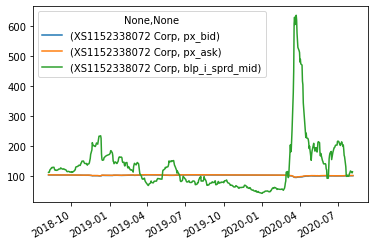

In [12]:
#bondDataHist.plot(x='nxt_call_dt',y='blp_i_sprd_mid')
bondDataHist.plot()

<class 'pandas.core.frame.DataFrame'>
MultiIndex([('XS1152338072 Corp',         'px_bid'),
            ('XS1152338072 Corp',         'px_ask'),
            ('XS1152338072 Corp', 'blp_i_sprd_mid')],
           )


131.57096078431374

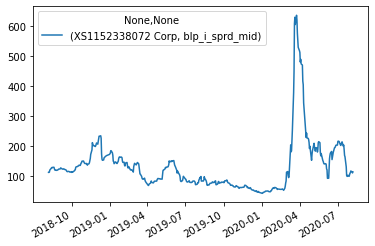

In [13]:
# plot just spread
print(type(bondDataHist))
#bondDataHist.plot(x=, y='blp_i_sprd_mid')

# works
#plt.plot(bondDataHist.index, bondDataHist.values)
# bondDataHist.plot(y='blp_i_sprd_mid', use_index=True)
bondDataHist.plot(y=('XS1152338072 Corp', 'blp_i_sprd_mid'))

# note this is a multi index (whatever that means)
print(bondDataHist.columns)

x = bondDataHist[('XS1152338072 Corp', 'blp_i_sprd_mid')]
x.mean()





## get data for multiple bonds




In [316]:
all_VW_bonds = ['XS1048428012', 'XS1206540806', 'XS1629658755', 'XS0968913342', 'XS1799938995', 
                'XS2187689034', 'XS1048428442', 'XS1629774230', 'XS1799939027', 'XS2187689380', 'XS1206541366']

listOfBonds = all_VW_bonds




In [15]:
def getHistoryFromISIN_list(isin_list: list):
    ''' function to get historic data from a list of isins  '''

    # list of isins
    isin_list = [i + ' Corp' for i in isin_list]
    print('here is the list: ', isin_list)

    # fields
    fieldList = 'blp_i_sprd_mid'

    # start and end dates to use
    dateToUseToday = datetime.date.today()
    dateToUse2yAgo = dateToUseToday + datetime.timedelta(days=-365*2)
    
    print('lets go between today and 2 years ago')
    print('today:', dateToUseToday)
    print('2y ago:', dateToUse2yAgo)



    # request from bbg returning a MultiIndex DataFrame object    
    bondDataHist = blp.bdh(
        tickers= isin_list, flds=fieldList,
        start_date=dateToUse2yAgo, end_date=dateToUseToday,
        )
    

    return bondDataHist

vwHist = getHistoryFromISIN_list(listOfBonds)
vwHist


here is the list:  ['XS1048428012 Corp', 'XS1206540806 Corp', 'XS1629658755 Corp', 'XS0968913342 Corp', 'XS1799938995 Corp', 'XS2187689034 Corp', 'XS1048428442 Corp', 'XS1629774230 Corp', 'XS1799939027 Corp', 'XS2187689380 Corp', 'XS1206541366 Corp']
lets go between today and 2 years ago
today: 2020-08-06
2y ago: 2018-08-07


,XS0968913342 Corp,XS1048428012 Corp,XS1048428442 Corp,XS1206540806 Corp,XS1206541366 Corp,XS1629658755 Corp,XS1629774230 Corp,XS1799938995 Corp,XS1799939027 Corp,XS2187689034 Corp,XS2187689380 Corp
,blp_i_sprd_mid,blp_i_sprd_mid,blp_i_sprd_mid,blp_i_sprd_mid,blp_i_sprd_mid,blp_i_sprd_mid,blp_i_sprd_mid,blp_i_sprd_mid,blp_i_sprd_mid,blp_i_sprd_mid,blp_i_sprd_mid
2018-08-07,258.495,172.862,301.264,239.065,322.071,250.143,342.041,302.528,350.895,NaN,NaN
2018-08-08,260.157,176.938,303.129,241.879,323.388,252.757,343.603,304.352,352.734,NaN,NaN
2018-08-09,262.464,177.999,305.343,244.183,325.933,255.857,346.341,308.124,355.732,NaN,NaN
2018-08-10,270.030,187.059,313.974,251.902,336.129,264.818,355.002,317.158,365.389,NaN,NaN
2018-08-13,276.130,192.834,321.628,257.964,339.368,270.573,362.965,322.693,370.882,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2020-07-30,348.315,245.468,383.229,322.722,405.000,333.690,398.044,381.019,416.669,406.943,424.642
2020-07-31,361.122,254.084,389.343,336.245,408.110,343.460,403.176,390.929,418.299,414.062,427.327
2020-08-03,371.283,260.501,392.284,341.745,412.225,351.338,407.283,395.475,421.717,418.061,429.129


the columns
Index(['XS1048428012', 'XS1206540806', 'XS1629658755', 'XS0968913342',
       'XS1799938995', 'XS2187689034', 'XS1048428442', 'XS1629774230',
       'XS1799939027', 'XS2187689380', 'XS1206541366'],
      dtype='object')
the means:
XS1048428012    290.113955
XS1206540806    223.390567
XS1629658755    351.148075
XS0968913342    276.749124
XS1799938995    355.357557
XS2187689034    294.063175
XS1048428442    381.942686
XS1629774230    337.360806
XS1799939027    389.979202
XS2187689380    395.851564
XS1206541366    419.199103
dtype: float64
the st devs:
XS1048428012     96.511266
XS1206540806    148.998802
XS1629658755     79.651263
XS0968913342    110.362539
XS1799938995     63.468858
XS2187689034    104.467882
XS1048428442     80.753077
XS1629774230     93.485129
XS1799939027     71.636389
XS2187689380     16.184428
XS1206541366     13.364355
dtype: float64


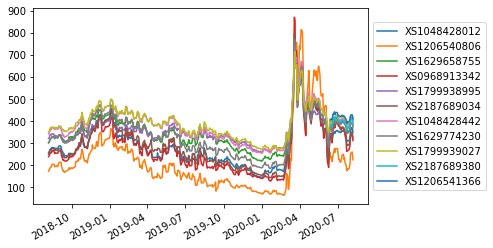

In [319]:
## do some basic stats

print('the columns')
vwHist.columns=all_VW_bonds
print(vwHist.columns)
print('the means:')
print(vwHist.mean())
print('the st devs:')
print(vwHist.std())

vwHist.plot().legend(all_VW_bonds, loc='center left', bbox_to_anchor=(1.0, 0.5))



# We need the current data (for the names instead of isins)

In [17]:
def getVWbondData(isin_list: list):
    ''' function to get VW bond data '''

    # isins
    isin_list = [i + " Corp" for i in isin_list]

    # fields
    fieldList = ['id_isin', 'security_name', 'name', 'cpn', 'nxt_call_dt', 'yas_ispread']

    vwDF = getListDataFromBbg(isin_list,  fieldList)


    return vwDF


vw = getVWbondData(all_VW_bonds)
vw

,id_isin,security_name,name,cpn,nxt_call_dt,yas_ispread
XS0968913342 Corp,XS0968913342,VW 5 1/8 PERP,VOLKSWAGEN INTL FIN NV,5.125,2023-09-04,340.394
XS1048428012 Corp,XS1048428012,VW 3 3/4 PERP,VOLKSWAGEN INTL FIN NV,3.75,2021-03-24,221.5
XS1048428442 Corp,XS1048428442,VW 4 5/8 PERP,VOLKSWAGEN INTL FIN NV,4.625,2026-03-24,377.443
XS1206540806 Corp,XS1206540806,VW 2 1/2 PERP,VOLKSWAGEN INTL FIN NV,2.5,2022-03-20,303.158
XS1206541366 Corp,XS1206541366,VW 3 1/2 PERP,VOLKSWAGEN INTL FIN NV,3.5,2030-03-20,405.51
XS1629658755 Corp,XS1629658755,VW 2.7 PERP,VOLKSWAGEN INTL FIN NV,2.7,2022-12-14,319.806
XS1629774230 Corp,XS1629774230,VW 3 7/8 PERP,VOLKSWAGEN INTL FIN NV,3.875,2027-06-14,395.046
XS1799938995 Corp,XS1799938995,VW 3 3/8 PERP,VOLKSWAGEN INTL FIN NV,3.375,2024-06-27,366.18
XS1799939027 Corp,XS1799939027,VW 4 5/8 PERP,VOLKSWAGEN INTL FIN NV,4.625,2028-06-27,410.2
XS2187689034 Corp,XS2187689034,VW 3 1/2 PERP,VOLKSWAGEN INTL FIN NV,3.5,2025-06-17,384.382


In [18]:
# sort by next call date

print(vw.columns)
print(vw.index)

vwsorted_byDate = vw.sort_values(by='nxt_call_dt')
vwsorted_byDate


Index(['id_isin', 'security_name', 'name', 'cpn', 'nxt_call_dt',
       'yas_ispread'],
      dtype='object')
Index(['XS0968913342 Corp', 'XS1048428012 Corp', 'XS1048428442 Corp',
       'XS1206540806 Corp', 'XS1206541366 Corp', 'XS1629658755 Corp',
       'XS1629774230 Corp', 'XS1799938995 Corp', 'XS1799939027 Corp',
       'XS2187689034 Corp', 'XS2187689380 Corp'],
      dtype='object')


,id_isin,security_name,name,cpn,nxt_call_dt,yas_ispread
XS1048428012 Corp,XS1048428012,VW 3 3/4 PERP,VOLKSWAGEN INTL FIN NV,3.75,2021-03-24,221.5
XS1206540806 Corp,XS1206540806,VW 2 1/2 PERP,VOLKSWAGEN INTL FIN NV,2.5,2022-03-20,303.158
XS1629658755 Corp,XS1629658755,VW 2.7 PERP,VOLKSWAGEN INTL FIN NV,2.7,2022-12-14,319.806
XS0968913342 Corp,XS0968913342,VW 5 1/8 PERP,VOLKSWAGEN INTL FIN NV,5.125,2023-09-04,340.394
XS1799938995 Corp,XS1799938995,VW 3 3/8 PERP,VOLKSWAGEN INTL FIN NV,3.375,2024-06-27,366.18
XS2187689034 Corp,XS2187689034,VW 3 1/2 PERP,VOLKSWAGEN INTL FIN NV,3.5,2025-06-17,384.382
XS1048428442 Corp,XS1048428442,VW 4 5/8 PERP,VOLKSWAGEN INTL FIN NV,4.625,2026-03-24,377.443
XS1629774230 Corp,XS1629774230,VW 3 7/8 PERP,VOLKSWAGEN INTL FIN NV,3.875,2027-06-14,395.046
XS1799939027 Corp,XS1799939027,VW 4 5/8 PERP,VOLKSWAGEN INTL FIN NV,4.625,2028-06-27,410.2
XS2187689380 Corp,XS2187689380,VW 3 7/8 PERP,VOLKSWAGEN INTL FIN NV,3.875,2029-06-17,410.271


### Here is the VW yield curve

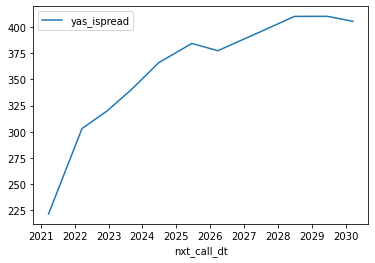

In [19]:
vwsorted_byDate.plot(x='nxt_call_dt', y='yas_ispread')

### merge the historic data to the current data


In [20]:
# merge table

def mergeDataFramesWithHistorySeries_vw(df1, df2):
    ''' 
    function to merge dataframes
        
    inputs: 
        df1: first dataframe
        df2: second dataframe

    outputs:
        dfOut: output DataFrame

    '''
    
    # print(type(df1))
    # print(type(df2))

    # print('\n\ndataframe 1')
    # print(df1)
    # print('\n\ndataframe 2')
    # print(df2)

    # Cannot merge a Series without a name => df2 needs to have a name  (solved with rename())
    # ValueError: cannot join with no overlapping index names (solved with droplevel())
    
    # drop level from MultiIndex series
    # df2 = df2.droplevel(level=1)


    # print('renamed df2:')
    # df2 = df2.rename('mean_2y')
    
    # print('df2 columns')
    # print(df2.columns)

    # print(df2)
    #dfOut = df1.merge(df2.rename('mean_2y'),left_index=True, right_index=True)
    dfOut = df1.merge(df2,left_index=True, right_index=True)
    # print('\n\noutput dataframe:')
    
    # print(dfOut)

    return dfOut

# run function (MultiLevel series renamed and dropped to single level)
vw_merged = mergeDataFramesWithHistorySeries_vw(vwsorted_byDate, vwHist.mean().rename('mean_2y').droplevel(level=1))
vw_merged = mergeDataFramesWithHistorySeries_vw(vw_merged, vwHist.std().rename('std_2y').droplevel(level=1))
vw_merged = mergeDataFramesWithHistorySeries_vw(vw_merged, vwHist.min().rename('min_2y').droplevel(level=1))
vw_merged = mergeDataFramesWithHistorySeries_vw(vw_merged, vwHist.max().rename('max_2y').droplevel(level=1))

# additional stats to add
vwmean = vwHist.ewm(halflife=0.5).mean().tail(1).transpose().reset_index().set_index('level_0')
del vwmean['level_1']
vwmean.columns.values[-1] = 'ewm' 
vw_merged = mergeDataFramesWithHistorySeries_vw(vw_merged, vwmean)

vw_merged






,id_isin,security_name,name,cpn,nxt_call_dt,yas_ispread,mean_2y,std_2y,min_2y,max_2y,ewm
XS1048428012 Corp,XS1048428012,VW 3 3/4 PERP,VOLKSWAGEN INTL FIN NV,3.75,2021-03-24,221.5,223.390567,148.998802,64.053,860.316,230.930551
XS1206540806 Corp,XS1206540806,VW 2 1/2 PERP,VOLKSWAGEN INTL FIN NV,2.5,2022-03-20,303.158,276.749124,110.362539,128.812,870.351,316.754643
XS1629658755 Corp,XS1629658755,VW 2.7 PERP,VOLKSWAGEN INTL FIN NV,2.7,2022-12-14,319.806,294.063175,104.467882,143.045,793.130,329.047272
XS0968913342 Corp,XS0968913342,VW 5 1/8 PERP,VOLKSWAGEN INTL FIN NV,5.125,2023-09-04,340.394,290.113955,96.511266,144.402,754.996,352.452044
XS1799938995 Corp,XS1799938995,VW 3 3/8 PERP,VOLKSWAGEN INTL FIN NV,3.375,2024-06-27,366.18,337.360806,93.485129,185.697,768.710,375.250463
XS2187689034 Corp,XS2187689034,VW 3 1/2 PERP,VOLKSWAGEN INTL FIN NV,3.5,2025-06-17,384.382,395.851564,16.184428,360.699,419.973,393.945146
XS1048428442 Corp,XS1048428442,VW 4 5/8 PERP,VOLKSWAGEN INTL FIN NV,4.625,2026-03-24,377.443,351.148075,79.651263,218.129,740.320,382.962004
XS1629774230 Corp,XS1629774230,VW 3 7/8 PERP,VOLKSWAGEN INTL FIN NV,3.875,2027-06-14,395.046,381.942686,80.753077,254.274,744.702,399.266132
XS1799939027 Corp,XS1799939027,VW 4 5/8 PERP,VOLKSWAGEN INTL FIN NV,4.625,2028-06-27,410.2,389.979202,71.636389,268.958,716.388,413.175428
XS2187689380 Corp,XS2187689380,VW 3 7/8 PERP,VOLKSWAGEN INTL FIN NV,3.875,2029-06-17,410.271,419.199103,13.364355,390.141,442.270,414.855425


### Add column to DataFrame for z-score

In [21]:
# add column to index

# list of differences
vw_merged['ispread-mean'] = vw_merged['yas_ispread'] - vw_merged['mean_2y']
vw_merged['z-score'] = vw_merged['ispread-mean'] / vw_merged['std_2y']
vw_merged['percentile'] = ((vw_merged['yas_ispread'] - vw_merged['min_2y']) / (vw_merged['max_2y'] - vw_merged['min_2y'])) 
vw_merged




,id_isin,security_name,name,cpn,nxt_call_dt,yas_ispread,mean_2y,std_2y,min_2y,max_2y,ewm,ispread-mean,z-score,percentile
XS1048428012 Corp,XS1048428012,VW 3 3/4 PERP,VOLKSWAGEN INTL FIN NV,3.75,2021-03-24,221.5,223.390567,148.998802,64.053,860.316,230.930551,-1.89106,-0.0126918,0.197732
XS1206540806 Corp,XS1206540806,VW 2 1/2 PERP,VOLKSWAGEN INTL FIN NV,2.5,2022-03-20,303.158,276.749124,110.362539,128.812,870.351,316.754643,26.4086,0.239289,0.235113
XS1629658755 Corp,XS1629658755,VW 2.7 PERP,VOLKSWAGEN INTL FIN NV,2.7,2022-12-14,319.806,294.063175,104.467882,143.045,793.130,329.047272,25.7429,0.246419,0.271905
XS0968913342 Corp,XS0968913342,VW 5 1/8 PERP,VOLKSWAGEN INTL FIN NV,5.125,2023-09-04,340.394,290.113955,96.511266,144.402,754.996,352.452044,50.2803,0.520978,0.320986
XS1799938995 Corp,XS1799938995,VW 3 3/8 PERP,VOLKSWAGEN INTL FIN NV,3.375,2024-06-27,366.18,337.360806,93.485129,185.697,768.710,375.250463,28.819,0.308274,0.309569
XS2187689034 Corp,XS2187689034,VW 3 1/2 PERP,VOLKSWAGEN INTL FIN NV,3.5,2025-06-17,384.382,395.851564,16.184428,360.699,419.973,393.945146,-11.4699,-0.708699,0.399546
XS1048428442 Corp,XS1048428442,VW 4 5/8 PERP,VOLKSWAGEN INTL FIN NV,4.625,2026-03-24,377.443,351.148075,79.651263,218.129,740.320,382.962004,26.2954,0.330131,0.305088
XS1629774230 Corp,XS1629774230,VW 3 7/8 PERP,VOLKSWAGEN INTL FIN NV,3.875,2027-06-14,395.046,381.942686,80.753077,254.274,744.702,399.266132,13.1031,0.162262,0.287039
XS1799939027 Corp,XS1799939027,VW 4 5/8 PERP,VOLKSWAGEN INTL FIN NV,4.625,2028-06-27,410.2,389.979202,71.636389,268.958,716.388,413.175428,20.2209,0.282272,0.315674
XS2187689380 Corp,XS2187689380,VW 3 7/8 PERP,VOLKSWAGEN INTL FIN NV,3.875,2029-06-17,410.271,419.199103,13.364355,390.141,442.270,414.855425,-8.92796,-0.668043,0.38616


### plot the new data

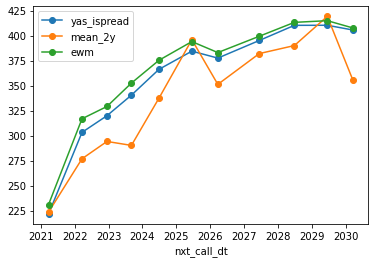

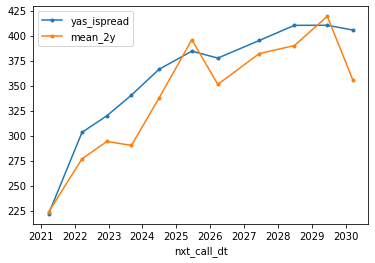

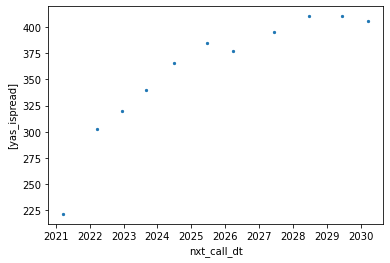

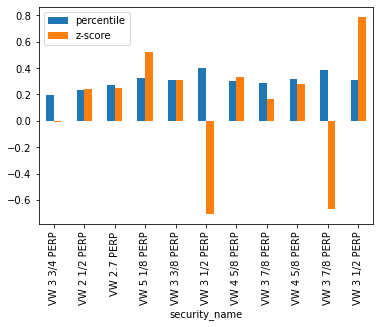

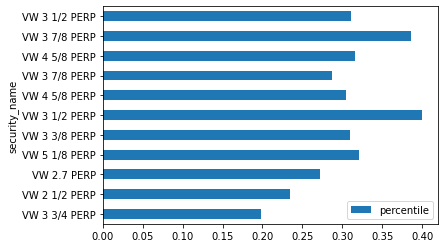

In [329]:
# plot data
vw_merged.plot(x='nxt_call_dt', y=['yas_ispread','mean_2y', 'ewm'], marker='o')
vw_merged.plot(x='nxt_call_dt', y=['yas_ispread','mean_2y'], marker='.')
vw_merged.plot(x='nxt_call_dt', y=['yas_ispread'], kind='scatter', marker='.')
vw_merged.plot(x='security_name', y=['percentile', 'z-score'] ,kind='bar')
vw_merged.plot(x='security_name', y='percentile' ,kind='barh')


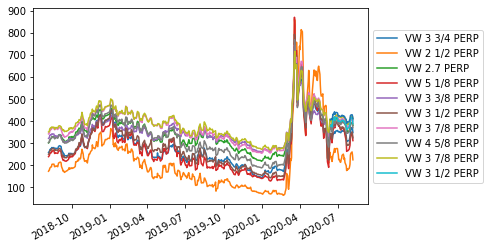

In [261]:
# Plot history with correct labels


ax = vwHist.plot()
# list of bonds
#print(vw_merged[['id_isin','security_name']])

# prepare legend list
legendList = []
for i in all_VW_bonds:
    counter = 0
    for j in vw_merged['id_isin']:
        if j == i:
            #print(i, j, vw_merged['security_name'][counter], counter)
            legendList.append(vw_merged['security_name'][counter])

        counter = counter + 1

# print(legendList)


# ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.legend(legendList, loc='center left', bbox_to_anchor=(1.0, 0.5))
ax


### subplots

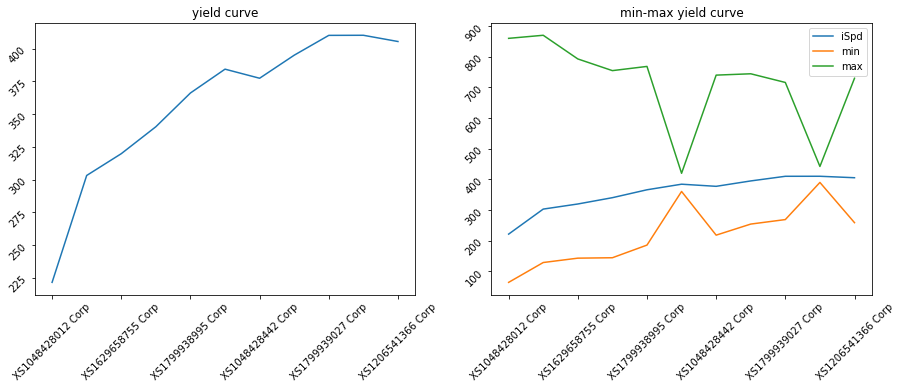

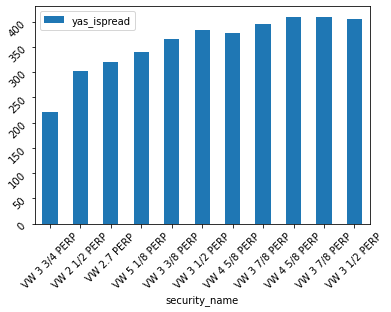

In [313]:
figs, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5) )

vw_merged['yas_ispread'].plot(ax=axes[0])
vw_merged['yas_ispread'].plot(ax=axes[1])
vw_merged['min_2y'].plot(ax=axes[1])
vw_merged['max_2y'].plot(ax=axes[1])

axes[0].set_title('yield curve')
axes[0].tick_params(labelrotation=45)
axes[1].legend(['iSpd','min','max'])
axes[1].set_title('min-max yield curve')
axes[1].tick_params(labelrotation=45)

vw_merged[['security_name', 'yas_ispread']].plot(x='security_name', y='yas_ispread', kind='bar').tick_params(labelrotation=45)



# Spread to Benchmark History
Define a benchmark bond and get the spread to benchmark history for all other bonds in the list.

In [202]:
def spreadToBenchmarkHistory(isinBench: str, isin_list: list):
    """
    define a benchmark bond and get spread to benchmark hiistory for bonds in hthe list.
    
        input:
            isinBench: the benchmark isin
            isin_list: the benchmark isins list
            
        output:
            df: dataframe containing benchmark histories
            
    """
    
    # remove benchmark from list
    if isinBench in isin_list:
        print('isin removed')
        isin_list.remove(isinBench)
    else:
        print('isin not in bench')
    

    # list of isins
    isin_list_corp = [i + ' Corp' for i in isin_list]
    print('here is the list: ', isin_list)
    

    # fields
    fieldList = 'blp_i_sprd_mid'

    # start and end dates to use
    dateToUseToday = datetime.date.today()
    dateToUse2yAgo = dateToUseToday + datetime.timedelta(days=-365*2)
    
    print('lets go between today and 2 years ago')
    print('today:', dateToUseToday)
    print('2y ago:', dateToUse2yAgo)



    # request from bbg returning a MultiIndex DataFrame object - for the isin list    
    bondDataHist = blp.bdh(
        tickers= isin_list_corp, flds=fieldList,
        start_date=dateToUse2yAgo, end_date=dateToUseToday,
        )

    # request from bbg returning a MultiIndex DataFrame object - for the isin benchmark  
    benchDataHist = blp.bdh(
        tickers= isinBench+ ' Corp', flds=fieldList,
        start_date=dateToUse2yAgo, end_date=dateToUseToday,
        )

    # MultiIndex dataframe for spreads
    spreadDataHist = bondDataHist.sub(benchDataHist[(isinBench+ ' Corp', 'blp_i_sprd_mid')], axis=0)
    
    # print(spreadDataHist)
    # rename columns
    spreadDataHist.columns = isin_list
    
    
    return spreadDataHist


benchmarkBond = 'XS1048428442'
vw_spd_to_bmk = spreadToBenchmarkHistory(benchmarkBond, listOfBonds)


#print(type(vw_spd_to_bmk))
#vw_spd_to_bmk.rename(columns={"('XS0968913342 Corp', 'blp_i_sprd_mid')": 'testBond'}, inplace=True)
vw_spd_to_bmk





isin not in bench
here is the list:  ['XS1048428012', 'XS1206540806', 'XS1629658755', 'XS0968913342', 'XS1799938995', 'XS2187689034', 'XS1629774230', 'XS1799939027', 'XS2187689380', 'XS1206541366']
lets go between today and 2 years ago
today: 2020-08-06
2y ago: 2018-08-07


,XS1048428012,XS1206540806,XS1629658755,XS0968913342,XS1799938995,XS2187689034,XS1629774230,XS1799939027,XS2187689380,XS1206541366
2018-08-07,-42.769,-128.402,-62.199,20.807,-51.121,40.777,1.264,49.631,NaN,NaN
2018-08-08,-42.972,-126.191,-61.250,20.259,-50.372,40.474,1.223,49.605,NaN,NaN
2018-08-09,-42.879,-127.344,-61.160,20.590,-49.486,40.998,2.781,50.389,NaN,NaN
2018-08-10,-43.944,-126.915,-62.072,22.155,-49.156,41.028,3.184,51.415,NaN,NaN
2018-08-13,-45.498,-128.794,-63.664,17.740,-51.055,41.337,1.065,49.254,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2020-07-31,-28.221,-135.259,-53.098,18.767,-45.883,13.833,1.586,28.956,24.719,37.984
2020-08-03,-21.001,-131.783,-50.539,19.941,-40.946,14.999,3.191,29.433,25.777,36.845
2020-08-04,-25.223,-143.202,-60.707,23.324,-49.385,15.673,-1.014,30.244,17.085,33.073
2020-08-05,-32.435,-155.807,-68.774,25.329,-55.996,16.585,-10.240,30.255,8.257,31.142


<class 'matplotlib.axes._subplots.AxesSubplot'>


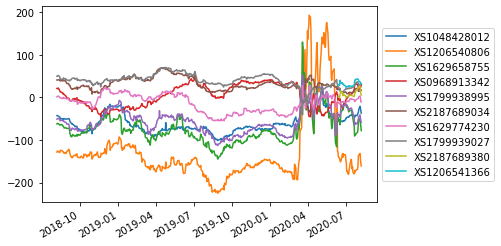

In [335]:
# plot this

ax = vw_spd_to_bmk.plot()
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
#ax.tight_layout()
ax

print(type(ax))

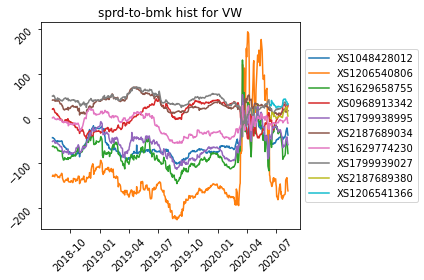

In [308]:
# method 2 for plotting
fig, ax = plt.subplots()
ax.plot(vw_spd_to_bmk)
ax.title.set_text('sprd-to-bmk hist for VW')
ax.legend(vw_spd_to_bmk.columns, loc='center left',bbox_to_anchor=(1.0, 0.5))
ax.tick_params(labelrotation=45)
fig.tight_layout()

# time stamp & save file
ts = datetime.datetime.now().strftime('%Y-%m-%d %H_%M_%S')
fileToSave = 'spreadImage ' + ts + '.png'
fileToSave = os.path.join(os.path.abspath(''), 'dataFolder', 'charts', fileToSave)

fig.savefig(fileToSave)



AttributeError: 'numpy.ndarray' object has no attribute 'tight_layout'

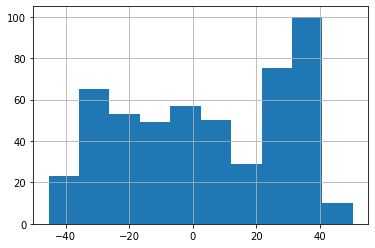

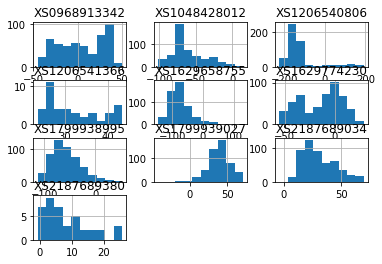

In [262]:
#plt.plot(vw_spd_to_bmk[('XS0968913342 Corp','blp_i_sprd_mid')], label='hello')
# plt.plot([2,3,4], label='world')
# plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
# plt.legend(legendList)


#print(type(vw_spd_to_bmk[('XS0968913342 Corp','blp_i_sprd_mid')]))
vw_spd_to_bmk[('XS0968913342')].hist()

vw_spd_to_bmk.hist()  #.subplots_adjust(hspace=0)



### some statistics

the mean is: 
 XS1048428012    -60.987104
XS1206540806   -127.822802
XS1629658755    -74.406153
XS0968913342      4.256750
XS1799938995    -57.087411
XS2187689034     30.767875
XS1629774230    -13.780787
XS1799939027     38.816487
XS2187689380      8.384950
XS1206541366     31.819800
dtype: float64
the standard deviation is: 
 XS1048428012    22.980580
XS1206540806    81.531743
XS1629658755    35.705649
XS0968913342    25.406683
XS1799938995    29.531668
XS2187689034    14.621485
XS1629774230    20.636999
XS1799939027    15.078328
XS2187689380     7.204380
XS1206541366     6.265229
dtype: float64
mean


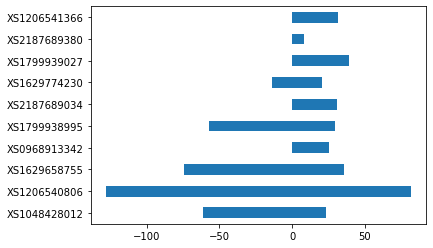

In [330]:

print('the mean is: \n', vw_spd_to_bmk.mean())
print('the standard deviation is: \n', vw_spd_to_bmk.std())
#x['blp_i_sprd_mid'].mean()

print('mean')
vw_spd_to_bmk.mean().plot(kind='barh')
vw_spd_to_bmk.std().plot(kind='barh')







# Blank line

# Blank line


## Get historic data from file

In [24]:


def getIsinHistoryFrom_File():
    '''
    function to get ISIN history from a file
    '''


    # import XLSX data file
    dir_path = os.path.abspath('')

    # get items from sheet (in a sub folder)
    fileToGet = 'hybrid_BBG_raw.xlsx'


    # join file and correct folder
    fileToGet = os.path.join(dir_path, 'dataFolder', 'xlsxData', fileToGet)
    print(fileToGet)
    print('getting the file')

    xl = pd.ExcelFile(fileToGet)

    print('got the file')


    # the names of the available sheets
    print('getting security list from:', xl.sheet_names)

    # print(type(xl))
    for name in xl.sheet_names:
        bhDF = xl.parse(name)
    
    # print(bhDF)
    return bhDF



r = getIsinHistoryFrom_File()
r




C:\Users\darren\OneDrive - Redhedge\code\bbg\corpHybrids\dataFolder\xlsxData\hybrid_BBG_raw.xlsx
getting the file
got the file
getting security list from: ['BBGhistV']


,date,XS1323897485,XS0992293901,BE6309987400,XS1323897725,DE000A14J611,DE000A11QR73,XS2077670003,XS2077670342,XS2182055009,...,XS1982704824,XS1934875219,XS0222524372,FR0011606169,XS1268050397,DE000A1ZN206,XS1582433428,XS2033327854,XS1642682410,XS1642686676
0,2020-08-03,-,-,-,-,-,-,-,-,-,...,550.96,-,-,-,-,-,1324.2,875.255,715.918,693.93
1,2020-08-02,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
2,2020-08-01,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
3,2020-07-31,199.929,261.097,280.502,304.007,244.623,300.284,312.898,339.922,326.396,...,546.384,1013.84,-,3244.52,-,402.808,1323.97,878.198,718.952,694.989
4,2020-07-30,192.987,258.664,276.202,298.452,237.742,294.986,307.711,338.752,319.703,...,547.089,1004.53,-,3081.33,-,373.009,1324.68,875.492,713.962,690.746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,2018-08-08,167.942,251.609,-,281.307,209.249,228.862,-,-,-,...,-,-,-,5751.42,147.189,186.178,624.108,-,487.18,510.434
727,2018-08-07,168.466,251.012,-,280.678,209.458,227.645,-,-,-,...,-,-,-,4969.6,147.37,185.226,625.415,-,518.357,527.292
728,2018-08-06,169.965,253.376,-,283.206,212.456,229.195,-,-,-,...,-,-,-,4699.75,145.109,187.663,622.905,-,528.721,533.74
729,2018-08-05,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-


# Now get the bond data


In [25]:
# put all isin's in a list
isin = df.iloc[:,1].tolist()
securtiyList = [x + " Corp" for x in isin]

# make the lists unique (and keep the order)
securtiyList = list(collections.OrderedDict.fromkeys(securtiyList))

# get the data from bloomberg
print('getting data from bbg')
bondData = getListDataFromBbg(securtiyList, fieldList)
print('the data is collected')

%time

getting data from bbg
70 of 184 remaining : loop 0
no data to add
70 of 184 remaining : loop 1
10 of 184 remaining : loop 2
the data is collected
Wall time: 0 ns


In [26]:
# We can inspect the shape ofthe data here
bondData.shape

(189, 15)

In [27]:
bondData

,ticker,coupon,nxt_call_dt,final_maturity,mty_typ,px_mid,z_sprd_mid,yas_ispread,yas_bond_yld,yas_risk,crncy,payment_rank,industry_sector,rtg_moody,rtg_sp
BE6309987400 Corp,SOLBBB,4.25,2023-12-04,NaN,PERP/CALL,106.073,286.871,286.889,2.44621,3.51335,EUR,Jr Subordinated,Basic Materials,Ba1,BB+
DE000A11QR73 Corp,BAYNGR,3.75,2024-07-01,2074-07-01,CALLABLE,104.716,288.297,288.239,2.46273,3.78011,EUR,Jr Subordinated,"Consumer, Non-cyclical",Baa3,BB+
DE000A14J611 Corp,BAYNGR,2.375,2022-10-02,2075-04-02,CALLABLE,100.971,233.837,233.762,1.90708,2.09857,EUR,Jr Subordinated,"Consumer, Non-cyclical",Baa3,BB+
DE000A161W62 Corp,DBOERS,2.75,2020-11-05,2041-02-05,CALLABLE,100.921,-66.4925,-67.8938,-1.09694,0.243869,EUR,Jr Subordinated,Financial,NaN,A+
DE000A289N78 Corp,DBOERS,1.25,2027-03-16,2047-06-16,CALLABLE,100.354,155.902,155.633,1.19394,6.32093,EUR,Subordinated,Financial,NaN,A+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XS1716927766 Corp,FERSM,2.124,2023-02-14,NaN,PERP/CALL,96.5225,389.512,389.351,3.46481,2.5281,EUR,Jr Subordinated,Industrial,NaN,BB+
XS1752984440 Corp,ARNDTN,2.125,2024-01-17,NaN,PERP/CALL,94.5965,425.366,425.334,3.82958,3.05325,EUR,Jr Subordinated,Financial,NaN,BBB-
XS1788973573 Corp,AKFAST,3.875,2023-07-08,2078-10-05,CALLABLE,102.056,360.421,360.322,3.17676,2.99936,EUR,Subordinated,Financial,NaN,BB+
XS1974894138 Corp,SBBBSS,4.625,2024-04-27,NaN,PERP/CALL,102.495,431.694,431.477,3.89365,3.44916,EUR,Jr Subordinated,Financial,NaN,BB


In [28]:
if bondData.shape[0] / len(isin):
    # remove duplicaes
    print('more rows than isins')
    bondData.drop_duplicates()

bondData.shape[0]



more rows than isins


189

# Time to save the Data to file



In [29]:
def store_data(someData):
    ''' function to store data to file 
    
    if data is stored:
        return: True otherwise False
    '''

    dataWritten = False

    # location to store file
    pathToStore = os.path.abspath('')
    # use a subfolder callled data folder
    pathToStore = os.path.join(pathToStore, 'dataFolder')
    print(f'the file resides here: {pathToStore}')

    # file name
    fileDateTime = datetime.datetime.now().strftime('%Y-%m-%d %H_%M_%S')
    

    fileToStoreXLSX = 'hybrids_results ' + fileDateTime + '.xlsx'
    fileToStoreHTML = 'hybrids_results ' + fileDateTime + '.html'
    print(f'the name of the excel file: {fileToStoreXLSX}')
    print(f'the name of the HTML file: {fileToStoreHTML}')

    # full path name
    fullPathToStoreXLSX = os.path.join(pathToStore, fileToStoreXLSX)
    fullPathToStoreHTML = os.path.join(pathToStore, fileToStoreHTML)    
    
    # save the file (to excel and html)
    df = pd.DataFrame(someData)
    df.to_excel(fullPathToStoreXLSX)
    df.to_html(fullPathToStoreHTML)
    dataWritten = True


    return dataWritten

In [30]:
# run the function to store data

storeIt = store_data(bondData)
if storeIt == True:
    print('the data is stored')
    
    

the file resides here: C:\Users\darren\OneDrive - Redhedge\code\bbg\corpHybrids\dataFolder
the name of the excel file: hybrids_results 2020-08-06 13_14_38.xlsx
the name of the HTML file: hybrids_results 2020-08-06 13_14_38.html
the data is stored


# Lets draw some example charts now

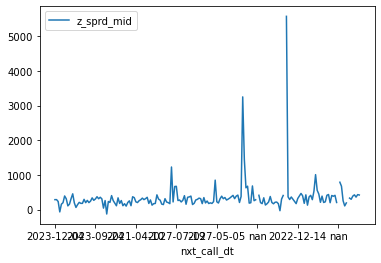

In [31]:
# plot maturity vs spread as a simple example directly from pandas
#bondData.plot(x='nxt_call_dt', y='z_sprd_mid',kind='scatter')
bondData.plot(x='nxt_call_dt',y='z_sprd_mid')



### a vertical bar chart

time taken:  0.37


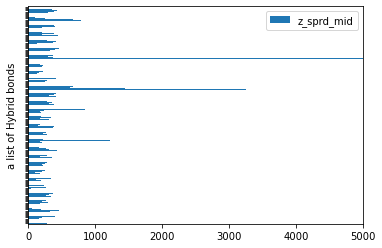

In [32]:
# plot a bar chart of the same data
# bondData.plot.bar(x='nxt_call_dt',y='z_sprd_mid')
t1 = time.time()


chart = bondData.plot(x='nxt_call_dt',y='z_sprd_mid', kind='barh')
chart.set_xlim(0,5000)

# change the y label
chart.set_ylabel('a list of Hybrid bonds')

# remove the y tick labels
chart.set_yticklabels([])




t2 = time.time()
print('time taken: ',round(t2-t1,2))





In [33]:
#bondData.hist(x='nxt_call_dt',y='z_sprd_mid')



### a histogram of the z spreads in the hybrid space

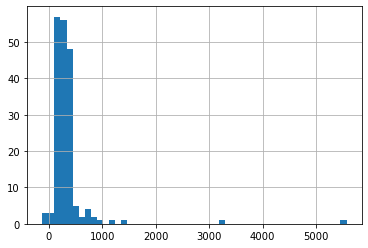

In [34]:
# convert to numeric
z_sprd_mid = pd.to_numeric(bondData['z_sprd_mid'])
yas_ispread = pd.to_numeric(bondData['yas_ispread'])


df = pd.DataFrame({
    'yas_ispread': yas_ispread,
    'z_sprd_mid':z_sprd_mid
    })

#hist = df['yas_ispread'].hist(bins=50)
#hist1 = df['z_sprd_mid'].hist(bins=50)


hist3 = bondData['z_sprd_mid'].hist(bins=50)




# Here are some statistics


In [35]:
# the average spread
x= bondData['z_sprd_mid'].mean()
x = round(x, 2)
print('the average z spread is:', x)


y= bondData['z_sprd_mid'].std()
y = round(y)
print('the standard deviation is:', y)

x, y = bondData['z_sprd_mid'].min() , bondData['z_sprd_mid'].max()
x, y = round(x), round(y)
print('min, max = ', x,",", y)

s = bondData['z_sprd_mid'].sem()
s = round(s,2)
print('standard error', s)



the average z spread is: 346.81
the standard deviation is: 479.0
min, max =  -127 , 5572
standard error 35.25


# lets get a regression

use the linear regression model in sklearn to get the linear regression.
example is here:


In [36]:
# linear regression

reg = linear_model.LinearRegression()

dependentVariables = bondData['nxt_call_dt'].values.reshape((-1,1))
independentVariables = bondData['z_sprd_mid'].values

# reg.fit(reg.fit([[0, 0], [1, 1], [2, 2]], [0, 1, 2]))

# model = reg.fit(dependentVariables,independentVariables)
# print(model)



# bonds crossing one year
This will be moved to a new module specifically for corporate hybrids.


In [37]:
# this will be moved to the hybrids module.



In [38]:
# oneYearBonds(bondData)

In [39]:
# delete the module so that it can be restarted for testing.
if 'hybridsMethods' in sys.modules:
    print('hybridsMethods was loaded')
    del sys.modules["hybridsMethods"]
    print('the module is now removed')


In [40]:
# import the hybrids module for testing
import hybridsMethods as hm

In [41]:

hm.oneYearBonds(100)



the hybrids module has been invoked
new things


0

# Other not used code...


In [42]:
def examples():
    """
    examples of how to get basic data from bbg
    """

    # get some data for a single name
    x = blp.bdp('BDEV LN Equity', 'px_last')
    print(x)
    print('the type of x', type(x))
    print('the value of x:', x.iloc[0]['px_last'])


    # get multiple data for a single name
    y = blp.bdp('BDEV LN Equity', flds=['px_bid', 'px_ask'])
    print(y)


    # get multiple data for multiple names
    z = blp.bdp(tickers=['BDEV LN Equity', 'BARC LN Equity'], flds=['px_bid', 'px_ask'])
    print(z)
    print('here is the bdev ask >>>', z.loc['BDEV LN Equity','px_ask'])

    # get multiple data for multiple names
    z = blp.bdp(tickers=['XS2011260705 Corp'], flds=['z_sprd_mid', 'z_sprd_mid'])
    print(z)
    print('here is the bdev ask >>>', z.loc['XS2011260705 Corp','z_sprd_mid'])

examples()


                px_last
BDEV LN Equity    502.4
the type of x <class 'pandas.core.frame.DataFrame'>
the value of x: 502.4
                px_bid  px_ask
BDEV LN Equity   502.2   502.6
                px_bid  px_ask
BARC LN Equity  104.74   104.8
BDEV LN Equity  502.20   502.6
here is the bdev ask >>> 502.6
                   z_sprd_mid  z_sprd_mid_1
XS2011260705 Corp  230.162598    230.162598
here is the bdev ask >>> 230.16259822271456


In [43]:
def get_bonds():
    """
    function to get bond data from bloomberg using tickers in an excel sheet.

    return:
        data - a pandas data set
    """

    print('getting bond data...')
    # securtiyList = ['US29265WAA62 Corp', 'XS1713463559 Corp', 'XS2000719992 Corp', 'XS0954675129 Corp', 'XS0954675129 Corp']
    fieldList = ['ticker', 'coupon', 'nxt_call_dt', 'final_maturity', 
                'mty_typ', 'px_mid', 'z_sprd_mid', 'yas_ispread', 'yas_bond_yld', 
                'yas_risk','crncy', 'payment_rank', 'industry_sector','rtg_moody','rtg_sp']

    # the script fis here
    #dir_path = os.path.dirname(os.path.realpath(__file__))
    dir_path = os.path.abspath('')


    # get items from sheet (in the same folder)
    fileToGet = 'hybridSecurityList.xlsx'
    # join file and correct folder
    fileToGet = os.path.join(dir_path, fileToGet)
    secListXlsx = pd.ExcelFile(fileToGet)
    
    # the names of the available sheets
    print('getting security list from:', secListXlsx.sheet_names)
    df = pd.DataFrame(secListXlsx.parse('tickers'))
    print('summary of the data')
    print(df.info)
    
    # put all isin's in a list
    isin = df.iloc[:,1].tolist()
    securtiyList = [x + " Corp" for x in isin]

    # make the lists unique (and keep the order)
    securtiyList = list(collections.OrderedDict.fromkeys(securtiyList))

    # get the data from bloomberg
    print('getting data from bbg')
    bondData = getListDataFromBbg(securtiyList, fieldList)

    #print('number of columns:', data.head())
    print('data is fetched:')
    print(bondData.info)

    return bondData

In [44]:
def main():

    # measure time for some basic examples
    t1 = time.time()
    
    # basic example (not used now)
    #examples()
    
    bondData = get_bonds()    
    t2 = time.time()

    # save data to file
    isStored = store_data(bondData)

    t3 = time.time()


    print('the time take is:', round(t2-t1, 3) , 'seconds')


In [45]:
# this works the same in a jupyter notebook which runs commands in sequence.
# there is no hoisting unless the code is added to a main() function.


if __name__ == "__main__":
    #main()
    pass




In [46]:
os.system('jupyter nbconvert --to html hybridsAnalysis 03.ipynb')


-1